In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importing required modules

import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10

import numpy as np
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm

import sys
sys.path.append("/content/drive/MyDrive/python_files")
from models import Models
from adversial_attack import AdversialAttack

import os
from PIL import Image

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Utility functions
def print_shapes(x_train, x_test, y_train, y_test):
  print(f"x_train: {x_train.shape}\n"\
      f"x_test: {x_test.shape}\n"\
      f"y_train: {y_train.shape}\n"\
      f"y_test: {y_test.shape}\n")

In [ ]:
# loading the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print_shapes(x_train, x_test, y_train, y_test)

170498071/170498071 [==============================] - 4s 0us/step
x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 1)
y_test: (10000, 1)



In [9]:
# Preprocessing images and labels
height, width, channels = 32, 32, 3
nb_classes = 10
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']


In [ ]:
x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, height, width, channels))
x_test = x_test.reshape((-1, height, width, channels))

y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
y_test = tf.keras.utils.to_categorical(y_test, nb_classes)

print_shapes(x_train, x_test, y_train, y_test)

In [3]:
model = Models.ResNet18Tf()

In [ ]:
# Training the model
model.compile(loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=8,
                    validation_data=(x_test, y_test))

Epoch 1/8
1563/1563 [==============================] - 41s 18ms/step - loss: 1.6078 - accuracy: 0.4131 - val_loss: 1.2709 - val_accuracy: 0.5380
Epoch 2/8
1563/1563 [==============================] - 27s 17ms/step - loss: 1.0517 - accuracy: 0.6295 - val_loss: 0.9347 - val_accuracy: 0.6772
Epoch 3/8
1563/1563 [==============================] - 27s 17ms/step - loss: 0.7838 - accuracy: 0.7271 - val_loss: 0.9330 - val_accuracy: 0.6890
Epoch 4/8
1563/1563 [==============================] - 28s 18ms/step - loss: 0.6335 - accuracy: 0.7833 - val_loss: 0.7421 - val_accuracy: 0.7505
Epoch 5/8
1563/1563 [==============================] - 28s 18ms/step - loss: 0.5213 - accuracy: 0.8219 - val_loss: 0.7056 - val_accuracy: 0.7696
Epoch 6/8
1563/1563 [==============================] - 28s 18ms/step - loss: 0.4364 - accuracy: 0.8519 - val_loss: 0.6222 - val_accuracy: 0.8061
Epoch 7/8
1563/1563 [==============================] - 27s 17ms/step - loss: 0.3749 - accuracy: 0.8728 - val_loss: 0.6979 - val_ac

In [5]:
adversial_attack = AdversialAttack()
#adv_in,adv_out = next(adversial_attack.adversary_generator(10000))

In [ ]:
adversial_attack.preprocessing()

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 1)
y_test: (10000, 1)

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 10)
y_test: (10000, 10)



In [6]:
adversial_attack.load_model()

In [ ]:
# Selecting random image for testing
rand_idx = randint(0,49999)
image = x_train[rand_idx].reshape((1, height, width, channels))
label = y_train[rand_idx]

In [24]:
# Select from file
image_directory = "/content/drive/MyDrive/custom_cifar10_test"
filename = "airplane.png"
label = label_names.index("airplane")

image_path = os.path.join(image_directory, filename)
img = Image.open(image_path).convert('RGB')

# Resize the image using LANCZOS
img = img.resize((32, 32), Image.LANCZOS)


one_hot_label = tf.keras.utils.to_categorical(label, 10)

# Convert the PIL Image to a NumPy array, normalize it and ensure correct data type
img_np = np.array(img) / 255.0
img_np = img_np.astype(np.float32)

# Add a batch dimension
img_np = np.expand_dims(img_np, axis=0)

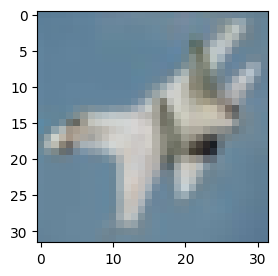

In [27]:
#print(f'Prediction from CNN: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(img_np.reshape((height, width, channels)))
plt.show()

In [ ]:
# Adding the adversary noise to image
epsilon = 0.05
perturbations = adversial_attack.generate_adversary(image,label).numpy()
adversarial = image + (perturbations * epsilon)

In [28]:
epsilon = 0.05

perturbations = adversial_attack.generate_adversary(img_np, one_hot_label).numpy()
# Remove the batch dimension before processing further
perturbations = np.squeeze(perturbations, axis=0)
adversarial = img_np[0] + (perturbations * epsilon)
#adversarial = np.clip(adversarial, 0, 1)
#adversarial = Image.fromarray((adversarial * 255).astype(np.uint8))

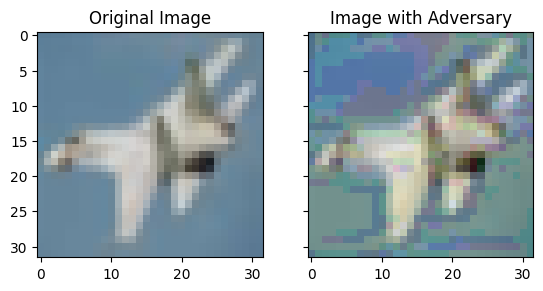

In [29]:
# Comparing both images
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(img_np.reshape(height,width, channels))
ax1.set_title("Original Image")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [30]:
adversarial = np.expand_dims(adversarial, axis=0)  # Add a batch dimension

adversial_attack.model(adversarial)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.05683645, 0.00270509, 0.2118984 , 0.14595923, 0.10923763,
        0.09081139, 0.0575744 , 0.04642466, 0.25541028, 0.02314242]],
      dtype=float32)>